# Imports and functions

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np

In [2]:
def load_dataframe_from_log(file_path, epochs):
    classes = []
    dice_scores = []
    accuracy_scores = []

    # Open the .log file
    with open(file_path, 'r') as file:
        # Read lines from the file in reverse order
        lines = file.readlines()[::-1]
        found_last_validation = False
        for line in lines:
            # Check if the line indicates the start of the last validation section
            if f'Epoch(val) [{epochs}]' in line:
                found_last_validation = True
                continue
            # If the last validation section from the 4th epoch is found, extract data
            if found_last_validation:
                # Use regular expressions to extract class names, dice scores, and accuracy scores
                match = re.match(r'\|\s+(\w[\w\s,]+)\s+\|\s+([\d.]+)\s+\|\s+([\d.]+)\s+\|', line)
                if match:
                    class_name = match.group(1).strip()
                    dice_score = float(match.group(2))
                    accuracy_score = float(match.group(3))
                    if class_name == 'background':
                        continue
                    classes.append(class_name)
                    dice_scores.append(dice_score)
                    accuracy_scores.append(accuracy_score)
                # Check if the end of the last validation section is reached
                if 'per class results:' in line:
                    break

    # Create a DataFrame from the extracted data
    data = {'Class': classes, 'Dice': dice_scores, 'Acc': accuracy_scores}
    df = pd.DataFrame(data)
    return df

# Model analysis

In [69]:
with open('../results/group.json') as f:
    data = json.load(f)
    ocrnet = pd.DataFrame(data['ocrnet'])
    pointrend = pd.DataFrame(data['point_rend'])
    dmnet = pd.DataFrame(data['dmnet'])
    
df = pd.concat([ocrnet, pointrend, dmnet])

In [70]:
df.head()

,network,backbone,pretrained,aAcc,mDice,mAcc,data_time,time,step
0,OCRNet,HRNet,ade,85.19,8.24,9.31,0.033609,0.086956,1
1,OCRNet,HRNet,ade,89.88,9.76,9.08,0.017576,0.071249,2
2,OCRNet,HRNet,cityscapes,88.52,6.96,6.85,0.032560,0.137402,1
3,OCRNet,HRNet,cityscapes,89.25,7.23,6.72,0.046495,0.164720,2
4,OCRNet,Resnet,cityscapes,87.84,8.88,9.09,0.032881,0.097223,1


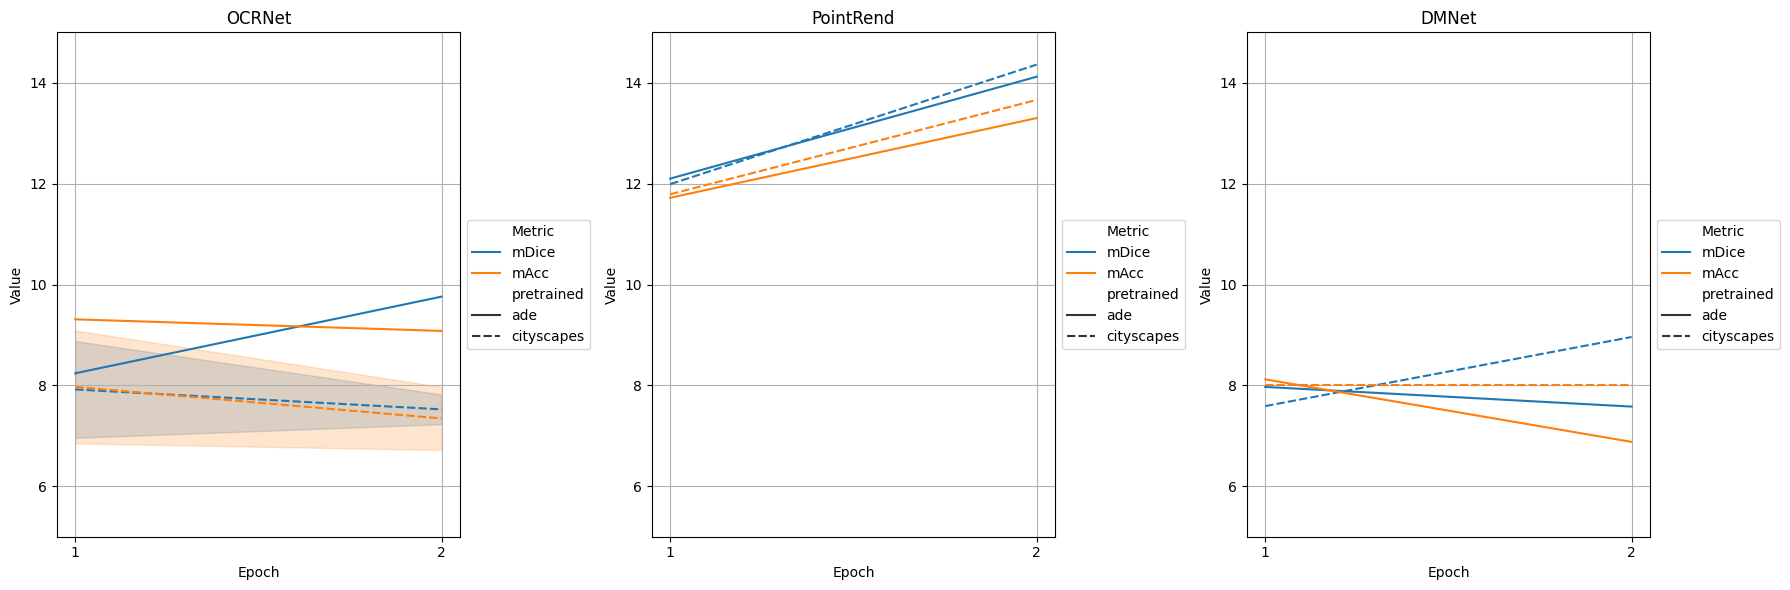

In [77]:
# Assuming you have already imported ocrnet, pointrend, and dmnet dataframes

# Melt the dataframes
ocrnet_melted = pd.melt(ocrnet, id_vars=['step', 'pretrained'], value_vars=['mDice', 'mAcc'], var_name='Metric', value_name='Value')
pointrend_melted = pd.melt(pointrend, id_vars=['step', 'pretrained'], value_vars=['mDice', 'mAcc'], var_name='Metric', value_name='Value')
dmnet_melted = pd.melt(dmnet, id_vars=['step', 'pretrained'], value_vars=['mDice', 'mAcc'], var_name='Metric', value_name='Value')

# Create subplots
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Plot using Seaborn
sns.lineplot(data=ocrnet_melted, x='step', y='Value', hue='Metric', style="pretrained", ax=ax[0])
ax[0].set_title("OCRNet")
ax[0].set_ylim(5, 15)
ax[0].set(xlabel='Epoch', ylabel='Value')
ax[0].set_xticks(df['step'].unique(), [1, 2])
ax[0].grid()

sns.lineplot(data=pointrend_melted, x='step', y='Value', hue='Metric', style="pretrained", ax=ax[1])
ax[1].set_title("PointRend")
ax[1].set_ylim(5, 15)
ax[1].set(xlabel='Epoch', ylabel='Value')
ax[1].set_xticks(df['step'].unique(), [1, 2])
ax[1].grid()

sns.lineplot(data=dmnet_melted, x='step', y='Value', hue='Metric', style="pretrained", ax=ax[2])
ax[2].set_title("DMNet")
ax[2].set_ylim(5, 15)
ax[2].set(xlabel='Epoch', ylabel='Value')
ax[2].set_xticks(df['step'].unique(), [1, 2])
ax[2].grid()

# Adjust legend
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[2].legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Show plot
plt.tight_layout()
plt.show()


# Batch size Analysis

In [54]:
with open('../results/group_batchsize.json') as f:
    data = json.load(f)

In [55]:
# Create an empty list to store data for the dataframe
df_list = []

# Loop through each key (batchsize) in the JSON data
for key, value in data.items():
  # For each value (list of dictionaries), append dictionaries with an extra column 'batchsize' set to the key
  for item in value:
    item['batchsize'] = key
    df_list.append(item)

# Create the dataframe from the list
df = pd.DataFrame(df_list)

# Print the dataframe
df.head()

,aAcc,mDice,mAcc,data_time,time,step,batchsize
0,91.11,12.10,11.72,0.018081,0.054526,1,2
1,91.82,14.12,13.30,0.016509,0.053082,2,2
2,92.04,16.11,15.22,0.033557,0.095723,3,2
3,92.09,15.72,14.74,0.016858,0.054110,4,2
4,91.14,12.15,11.11,0.014900,0.037200,1,4


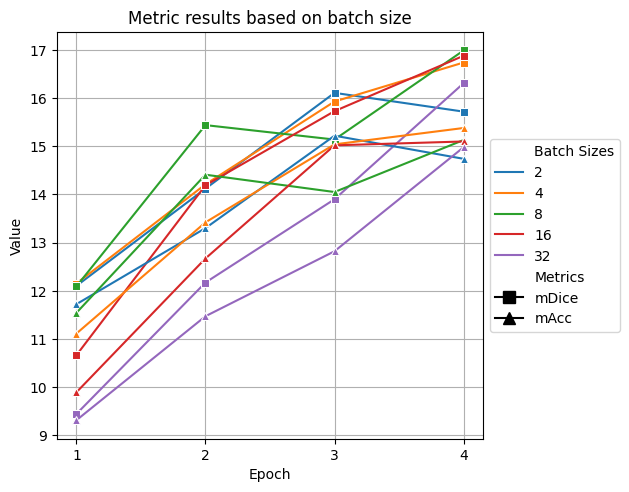

In [61]:
# Define the metrics you want to plot (replace with your desired columns)
metrics = ['mDice', 'mAcc']

marker_styles = {'mDice': 's', 'mAcc': '^'}

# Create a subplot for each metric

for metric, marker in zip(metrics, marker_styles.values()):
  ax = sns.lineplot(x='step', y=metric, marker=marker, hue='batchsize', data=df)
  
# Create a custom legend
handles = []
labels = []
batch_sizes_seen = set()
handles.append(plt.Line2D([], [], color='black', marker='', linestyle='None', label='Batch Sizes'))
labels.append('Batch Sizes')
# Add batch sizes with colors to the legend
for batch_size, color in zip(df['batchsize'].unique(), sns.color_palette()):
    handles.append(plt.Line2D([], [], color=color, markersize=8, linestyle='-', label=batch_size))
    labels.append(batch_size)
    
handles.append(plt.Line2D([], [], color='black', marker='', linestyle='None', label='Metrics'))
labels.append('Metrics')
for batch_size, marker in marker_styles.items():
    if batch_size in batch_sizes_seen:
        continue
    handles.append(plt.Line2D([], [], color='black', marker=marker, markersize=8, linestyle='-'))
    labels.append(batch_size)
    batch_sizes_seen.add(batch_size)

ax.set(xlabel='Epoch', ylabel='Value')
plt.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.title("Metric results based on batch size")
plt.xticks(df['step'].unique(), [1, 2, 3, 4])
plt.grid()
plt.show()

# Image resolution

In [3]:
with open('../results/group_imageres.json') as f:
    data = json.load(f)

In [4]:
# Create an empty list to store data for the dataframe
df_list = []

# Loop through each key (batchsize) in the JSON data
for key, value in data.items():
  # For each value (list of dictionaries), append dictionaries with an extra column 'batchsize' set to the key
  for item in value:
    item['image_resolution'] = key
    df_list.append(item)

# Create the dataframe from the list
df = pd.DataFrame(df_list)

# Print the dataframe
df.head()

,aAcc,mDice,mAcc,data_time,time,step,image_resolution
0,91.70,12.09,11.54,0.026481,0.066416,1,192
1,92.20,15.44,14.41,0.014905,0.037172,2,192
2,92.52,15.14,14.05,0.014613,0.036997,3,192
3,92.66,16.99,15.13,0.014726,0.037496,4,192
4,92.79,16.27,14.93,0.023043,0.139905,1,384


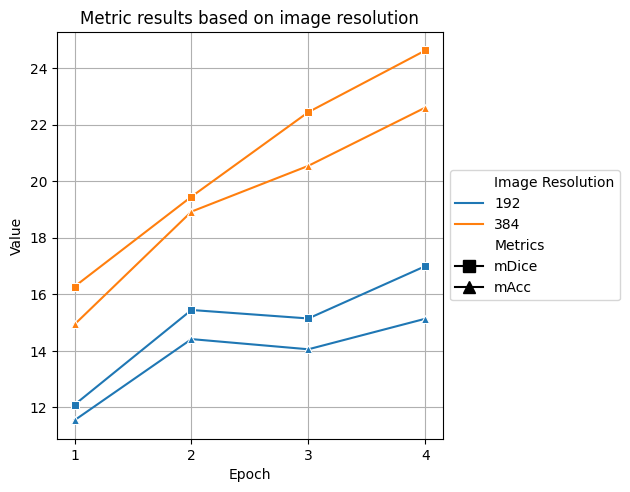

In [5]:
# Define the metrics you want to plot (replace with your desired columns)
metrics = ['mDice', 'mAcc']

marker_styles = {'mDice': 's', 'mAcc': '^'}

# Create a subplot for each metric

for metric, marker in zip(metrics, marker_styles.values()):
  ax = sns.lineplot(x='step', y=metric, marker=marker, hue='image_resolution', data=df)
  
# Create a custom legend
handles = []
labels = []
batch_sizes_seen = set()
handles.append(plt.Line2D([], [], color='black', marker='', linestyle='None', label='Image Resolution'))
labels.append('Image Resolution')
# Add batch sizes with colors to the legend
for batch_size, color in zip(df['image_resolution'].unique(), sns.color_palette()):
    handles.append(plt.Line2D([], [], color=color, markersize=8, linestyle='-', label=batch_size))
    labels.append(batch_size)
    
handles.append(plt.Line2D([], [], color='black', marker='', linestyle='None', label='Metrics'))
labels.append('Metrics')
for batch_size, marker in marker_styles.items():
    if batch_size in batch_sizes_seen:
        continue
    handles.append(plt.Line2D([], [], color='black', marker=marker, markersize=8, linestyle='-'))
    labels.append(batch_size)
    batch_sizes_seen.add(batch_size)

ax.set(xlabel='Epoch', ylabel='Value')
plt.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.xticks(df['step'].unique(), [1, 2, 3, 4])
plt.title("Metric results based on image resolution")
plt.grid()
plt.show()

In [6]:
df_192 = load_dataframe_from_log('../results/pointrend_8bs.log', 4)

In [7]:
df_192.head()

,Class,Dice,Acc
0,tassel,0.00,0.00
1,sequin,0.00,0.00
2,ruffle,8.86,4.64
3,rivet,0.00,0.00
4,ribbon,0.00,0.00


In [8]:
df_384 = load_dataframe_from_log('../results/pointrend_4epoch_8bs_384ir.log', 4)

In [9]:
df_384.head()

,Class,Dice,Acc
0,tassel,0.00,0.00
1,sequin,0.00,0.00
2,ruffle,22.14,12.71
3,rivet,0.00,0.00
4,ribbon,0.00,0.00


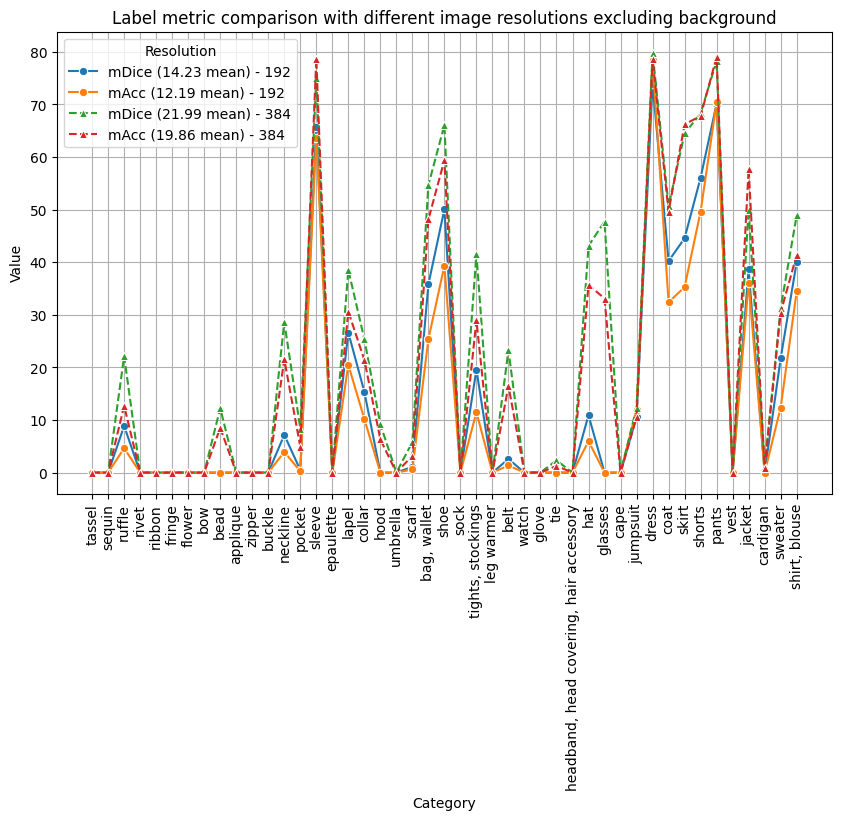

In [10]:
# Plot 'Dice' using Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_192, x='Class', y='Dice', label=f'mDice ({df_192["Dice"].mean():.2f} mean) - 192', marker='o')
sns.lineplot(data=df_192, x='Class', y='Acc', label=f'mAcc ({df_192["Acc"].mean():.2f} mean) - 192', marker='o')


# Plot 'Acc' using Seaborn
sns.lineplot(data=df_384, x='Class', y='Dice', label=f'mDice ({df_384["Dice"].mean():.2f} mean) - 384', marker='^', linestyle='--')
ax = sns.lineplot(data=df_384, x='Class', y='Acc', label=f'mAcc ({df_384["Acc"].mean():.2f} mean) - 384', marker='^', linestyle='--')

ax.set(xlabel='Category', ylabel='Value')
plt.xticks(rotation=90)
plt.title("Label metric comparison with different image resolutions excluding background")
plt.legend(title='Resolution')
plt.grid()
plt.show()

# Reduction

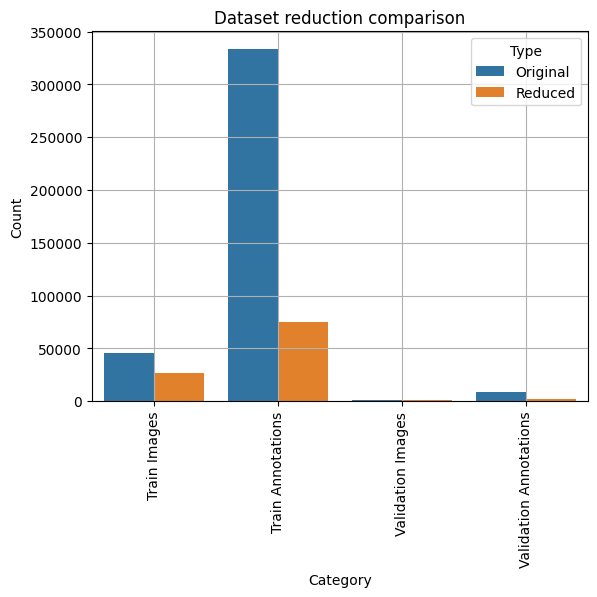

In [11]:
# Define the labels and data
categories = ['Train Images', 'Train Annotations', 'Validation Images', 'Validation Annotations']
data = [45623, 333401, 1158, 8781, 26227, 74992, 658, 1767]

# Create a DataFrame
df = pd.DataFrame({'Category': categories*2,
                   'Count': data,
                   'Type': ['Original']*len(categories) + ['Reduced']*len(categories)})

# Create the bar plot
ax = sns.barplot(x='Category', y='Count', hue='Type', data=df)

plt.xticks(rotation=90)
plt.title("Dataset reduction comparison")
plt.grid()
plt.show()

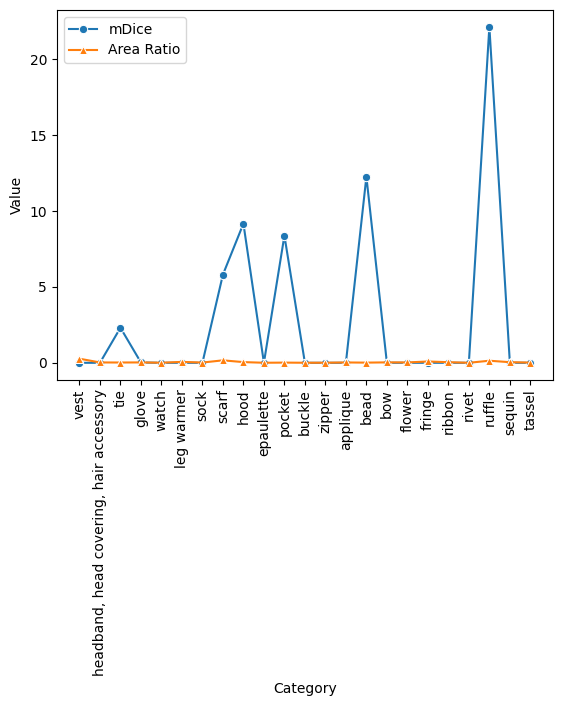

In [12]:
df_filtered = pd.read_csv('filtered_results.csv')

sns.lineplot(data=df_filtered, x='cat', y='dice', label='mDice', marker='o')
ax = sns.lineplot(data=df_filtered, x='cat', y='area_ratio', label='Area Ratio', marker='^')
ax.set(xlabel='Category', ylabel='Value')
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [17]:
df_reduced = load_dataframe_from_log('../results/pointrend_2epoch_8bs_384ir_ade_reduced.log', 2)

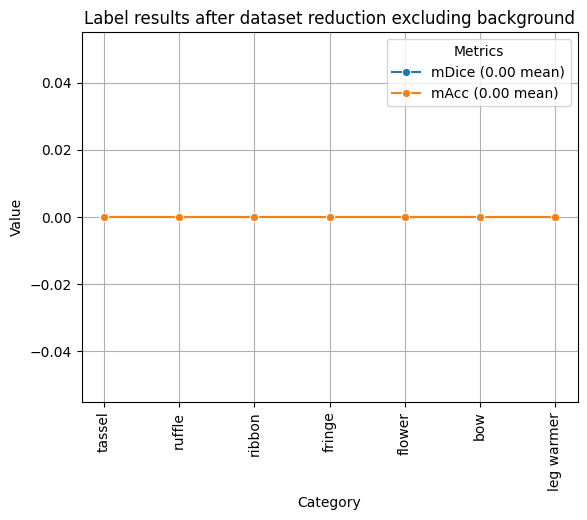

In [18]:
# Plot 'Acc' using Seaborn
sns.lineplot(data=df_reduced, x='Class', y='Dice', label=f'mDice ({df_reduced["Dice"].mean():.2f} mean)', marker='o')
ax = sns.lineplot(data=df_reduced, x='Class', y='Acc', label=f'mAcc ({df_reduced["Acc"].mean():.2f} mean)', marker='o')

ax.set(xlabel='Category', ylabel='Value')
plt.xticks(rotation=90)
plt.title("Label results after dataset reduction excluding background")
plt.legend(title='Metrics')
plt.grid()
plt.show()

# Data augmentation

In [19]:
df_aug = load_dataframe_from_log('../results/PointRend_aug_8bs_4ep_384im.log', 4)
df_aug

,Class,Dice,Acc
0,tassel,0.00,0.00
1,sequin,0.00,0.00
2,ruffle,18.56,10.26
3,rivet,0.00,0.00
4,ribbon,0.00,0.00
5,fringe,0.00,0.00
6,flower,0.00,0.00
7,bow,0.00,0.00
8,bead,0.00,0.00
9,applique,0.00,0.00


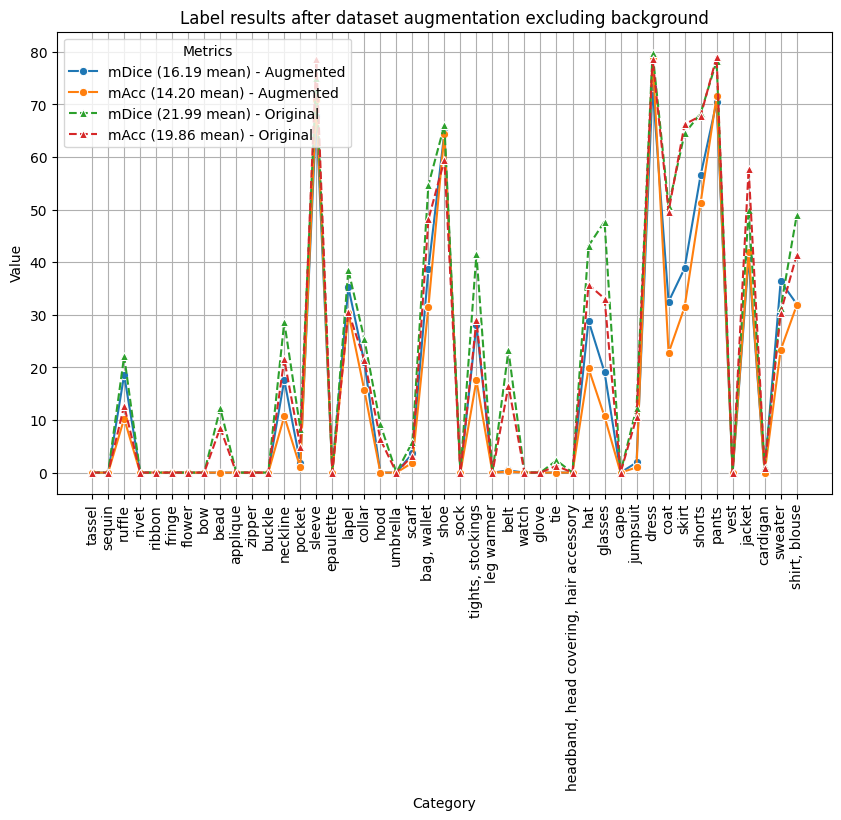

In [27]:
plt.figure(figsize=(10, 6))
# Augmented data
sns.lineplot(data=df_aug, x='Class', y='Dice', label=f'mDice ({df_aug["Dice"].mean():.2f} mean) - Augmented', marker='o')
ax = sns.lineplot(data=df_aug, x='Class', y='Acc', label=f'mAcc ({df_aug["Acc"].mean():.2f} mean) - Augmented', marker='o')

# 384 image resolution data for comparison
sns.lineplot(data=df_384, x='Class', y='Dice', label=f'mDice ({df_384["Dice"].mean():.2f} mean) - Original', marker='^', linestyle='--')
ax = sns.lineplot(data=df_384, x='Class', y='Acc', label=f'mAcc ({df_384["Acc"].mean():.2f} mean) - Original', marker='^', linestyle='--')

ax.set(xlabel='Category', ylabel='Value')
plt.xticks(rotation=90)
plt.title("Label results after dataset augmentation excluding background")
plt.legend(title='Metrics')
plt.grid()
plt.show()